In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(r"C:\Users\user\Downloads\cleaned_dataset.csv")
df.head()

,Date,DXY_Index,d_DXY,USD_CNY,USD_RUB,USD_EUR,Fed_Rate,Treasury_10Y,Treasury_2Y,TIPS_10Y,...,Real_Rate_Calc,Yield_Curve_10Y2Y,GLD_Return_3M,GLD_Gold_Premium,Gold_Mining_Margin,Geopolitics_Shock,Gold_Return,Return_Lag1,d_RealRate,d_DXY.1
0,2005-04-01,84.430000,0.370003,8.266501,27.804501,1.290906,2.79,4.46,3.75,1.77,...,4.14928,0.71,-0.061234,-89.992956,2235.330114,0,-0.006553,0.006318,0.133106,0.370003
1,2005-04-04,84.779999,0.349998,8.266501,27.889999,1.285000,2.79,4.46,3.75,1.77,...,4.14928,0.71,-0.060284,-89.997640,2235.330114,0,-0.004707,-0.006553,0.000000,0.349998
2,2005-04-05,84.660004,-0.119995,8.266501,27.879999,1.285793,2.79,4.46,3.75,1.77,...,4.14928,0.71,-0.064566,-90.000000,2235.330114,0,0.001414,-0.004707,0.000000,-0.119995
3,2005-04-06,84.680000,0.019997,8.266501,27.872999,1.286703,2.79,4.46,3.75,1.77,...,4.14928,0.71,-0.051613,-90.018731,2235.330114,0,0.006106,0.001414,0.000000,0.019997
4,2005-04-07,84.870003,0.190002,8.266501,27.798000,1.285000,2.79,4.46,3.75,1.77,...,4.14928,0.71,-0.066447,-90.018757,2235.330114,0,-0.001406,0.006106,0.000000,0.190002


In [2]:
df.drop(df.columns[-1], axis=1, inplace=True)
df.head()

,Date,DXY_Index,d_DXY,USD_CNY,USD_RUB,USD_EUR,Fed_Rate,Treasury_10Y,Treasury_2Y,TIPS_10Y,...,GDP_Growth_QoQ,Real_Rate_Calc,Yield_Curve_10Y2Y,GLD_Return_3M,GLD_Gold_Premium,Gold_Mining_Margin,Geopolitics_Shock,Gold_Return,Return_Lag1,d_RealRate
0,2005-04-01,84.430000,0.370003,8.266501,27.804501,1.290906,2.79,4.46,3.75,1.77,...,2.0,4.14928,0.71,-0.061234,-89.992956,2235.330114,0,-0.006553,0.006318,0.133106
1,2005-04-04,84.779999,0.349998,8.266501,27.889999,1.285000,2.79,4.46,3.75,1.77,...,2.0,4.14928,0.71,-0.060284,-89.997640,2235.330114,0,-0.004707,-0.006553,0.000000
2,2005-04-05,84.660004,-0.119995,8.266501,27.879999,1.285793,2.79,4.46,3.75,1.77,...,2.0,4.14928,0.71,-0.064566,-90.000000,2235.330114,0,0.001414,-0.004707,0.000000
3,2005-04-06,84.680000,0.019997,8.266501,27.872999,1.286703,2.79,4.46,3.75,1.77,...,2.0,4.14928,0.71,-0.051613,-90.018731,2235.330114,0,0.006106,0.001414,0.000000
4,2005-04-07,84.870003,0.190002,8.266501,27.798000,1.285000,2.79,4.46,3.75,1.77,...,2.0,4.14928,0.71,-0.066447,-90.018757,2235.330114,0,-0.001406,0.006106,0.000000


In [3]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import TimeSeriesSplit

# --- 1. ПЕРЕДОВАЯ ПОДГОТОВКА ФИЧ ---
df = df.copy()

# Доходности
df['gold_ret'] = df['Gold_Price'].pct_change()
df['dxy_ret'] = df['DXY_Index'].pct_change()

# Расчет RSI (если не был рассчитан)
window_rsi = 14
delta = df['Gold_Price'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=window_rsi).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=window_rsi).mean()
rs = gain / (loss + 1e-9)
df['gold_rsi'] = 100 - (100 / (1 + rs))

# Z-Score и кумулятивные данные
df['z_score'] = (df['Gold_Price'] - df['Gold_Price'].rolling(20).mean()) / (df['Gold_Price'].rolling(20).std() + 1e-9)
df['etf_diff'] = df['GLD_Price'].pct_change() - df['gold_ret']
df['gs_ratio_ret'] = df['Gold_Silver_Ratio'].pct_change()

# НОВАЯ ФИЧА: Относительная волатильность (насколько сегодня "жарко")
df['volatility_ratio'] = df['gold_ret'].rolling(5).std() / df['gold_ret'].rolling(20).std()

# --- 2. УМНЫЙ ТАРГЕТ С ФИЛЬТРАЦИЕЙ ШУМА ---
# Предсказываем движение только если волатильность выше среднего. 
# Это помогает модели не гадать на "плоском" рынке.
vol_threshold = df['gold_ret'].std() * 0.5 
df['target_bin'] = np.where(df['gold_ret'].shift(-1) > vol_threshold, 1, 
                            np.where(df['gold_ret'].shift(-1) < -vol_threshold, 0, np.nan))

# Очистка (убираем строки, где таргет - шум)
df.dropna(subset=['target_bin'] + ['VIX_Index', 'z_score', 'etf_diff'], inplace=True)

# Список фич-лидеров
features = ['VIX_Index', 'z_score', 'etf_diff', 'gs_ratio_ret', 'gold_rsi', 'volatility_ratio', 'dxy_ret']

X = df[features]
y = df['target_bin']

# --- 3. КРОСС-ВАЛИДАЦИЯ С УЖЕСТОЧЕННЫМИ ПАРАМЕТРАМИ ---
tscv = TimeSeriesSplit(n_splits=5)
scores_acc = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = xgb.XGBClassifier(
        n_estimators=500, 
        learning_rate=0.01,
        max_depth=3,
        gamma=1.0,           # Сильная обрезка веток
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    scores_acc.append(accuracy_score(y_test, preds))

print(f"Итоговая точность на очищенных данных: {np.mean(scores_acc):.2%}")

Итоговая точность на очищенных данных: 60.32%


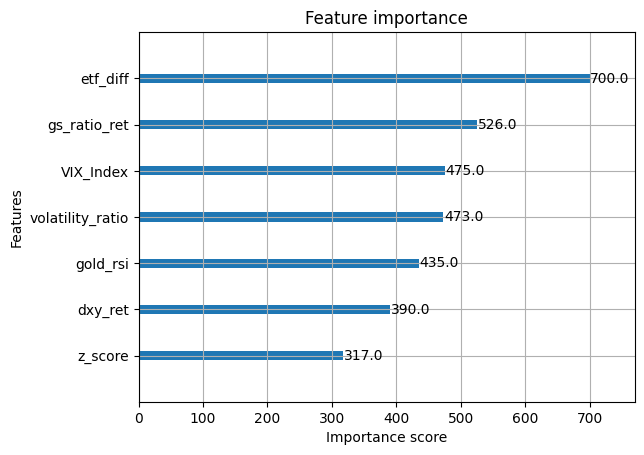

In [4]:
import matplotlib.pyplot as plt
xgb.plot_importance(model, max_num_features=10)
plt.show()

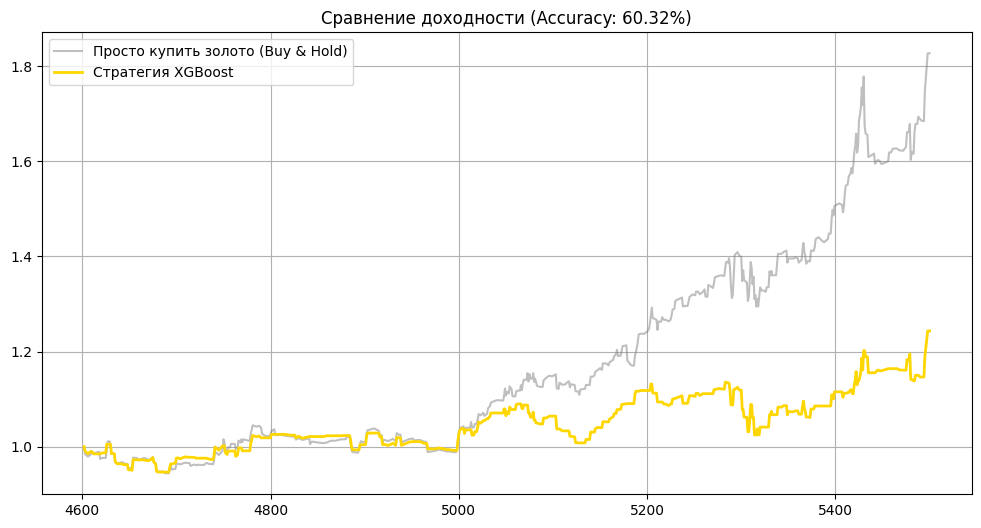

In [5]:
import matplotlib.pyplot as plt

# Берем последний тестовый кусок для наглядности
# Сигнал: если модель предсказала 1, мы в позиции. Если 0 - мы вне рынка (или в шорте)
test_returns = df.iloc[test_index]['gold_ret']
strategy_returns = preds * test_returns 

# Считаем накопительную доходность
cum_market = (1 + test_returns).cumprod()
cum_strategy = (1 + strategy_returns).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(cum_market, label='Просто купить золото (Buy & Hold)', color='gray', alpha=0.5)
plt.plot(cum_strategy, label='Стратегия XGBoost', color='gold', linewidth=2)
plt.title(f'Сравнение доходности (Accuracy: {np.mean(scores_acc):.2%})')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# 1. Берем последнюю известную строку данных (сегодня)
latest_data = X.tail(1)
current_price = df['Gold_Price'].iloc[-1]

# 2. Получаем вероятность роста от модели
prob_up = model.predict_proba(latest_data)[0][1]

# 3. Рассчитываем ожидаемую цену
# Средний ход золота (волатильность) для масштаба
avg_move = df['gold_ret'].abs().mean()

expected_return = (prob_up - 0.5) * 2 * avg_move
predicted_price = current_price * (1 + expected_return)

print(f"--- ПРОГНОЗ НА СЛЕДУЮЩИЙ ДЕНЬ ---")
print(f"Текущая цена: {current_price:.2f}$")
print(f"Вероятность роста: {prob_up:.2%}")
print(f"Ожидаемая цена завтра: {predicted_price:.2f}$")
print(f"Рекомендация: {'BUY' if prob_up > 0.55 else 'SELL' if prob_up < 0.45 else 'HOLD'}")

--- ПРОГНОЗ НА СЛЕДУЮЩИЙ ДЕНЬ ---
Текущая цена: 5079.90$
Вероятность роста: 66.04%
Ожидаемая цена завтра: 5092.82$
Рекомендация: BUY


In [7]:
import pandas as pd
import numpy as np

# 1. ПОДГОТОВКА ГОРИЗОНТОВ (1, 3, 5 лет)
current_price = df['Gold_Price'].iloc[-1]
last_date = df.index[-1]
months = 60  # Прогноз на 5 лет (60 месяцев)
forecast_dates = pd.date_range(start=last_date, periods=months + 1, freq='M')[1:]

# Параметры волатильности для интервалов
monthly_vol = df['gold_ret'].std() * np.sqrt(21) # Месячная волатильность

# 2. ФУНКЦИЯ ГЕНЕРАЦИИ СЦЕНАРИЕВ
def generate_scenarios(base_prob, price_start, periods):
    # Коэффициенты для сценариев согласно заданию [cite: 30]
    # Оптимистичный: рост вероятности при панике (VIX+) или низких ставках
    opt_factor = 1.15  
    # Пессимистичный: давление доллара или рост ставок
    pess_factor = 0.85 
    
    results = []
    for i in range(1, periods + 1):
        # Базовый (наиболее вероятный) [cite: 30]
        drift_base = (base_prob - 0.5) * 2 * monthly_vol * i
        p_base = price_start * (1 + drift_base)
        
        # Оптимистичный [cite: 31]
        p_opt = price_start * (1 + drift_base * opt_factor + (0.01 * i))
        
        # Пессимистичный [cite: 32]
        p_pess = price_start * (1 + drift_base * pess_factor - (0.01 * i))
        
        # Доверительные интервалы (статистическая чистка по заданию) [cite: 33, 64]
        margin_80 = 1.28 * monthly_vol * np.sqrt(i) * price_start
        margin_95 = 1.96 * monthly_vol * np.sqrt(i) * price_start
        
        results.append([
            forecast_dates[i-1], p_base, p_opt, p_pess,
            p_base - margin_80, p_base + margin_80,
            p_base - margin_95, p_base + margin_95
        ])
    return results

# Получаем вероятность из вашей последней модели
prob_up = model.predict_proba(X.tail(1))[0][1]

# Создаем таблицу
columns = ['Date', 'Base_Scenario', 'Optimistic', 'Pessimistic', 
           'Conf_80_Low', 'Conf_80_High', 'Conf_95_Low', 'Conf_95_High']
data = generate_scenarios(prob_up, current_price, months)
forecast_df = pd.DataFrame(data, columns=columns)

# 3. АГРЕГАЦИЯ ДЛЯ ПРЕЗЕНТАЦИИ 
print("Средний прогноз по периодам:")
print(f"1 год (базовый): {forecast_df.iloc[:12]['Base_Scenario'].mean():.2f}")
print(f"3 года (базовый): {forecast_df.iloc[:36]['Base_Scenario'].mean():.2f}")
print(f"5 лет (базовый): {forecast_df.iloc[:60]['Base_Scenario'].mean():.2f}")

# Сохранение для сдачи (пункт 2 требований) 
forecast_df.to_csv('gold_forecast_scenarios.csv', index=False)

Средний прогноз по периодам:
1 год (базовый): 5650.56
3 года (базовый): 6704.09
5 лет (базовый): 7757.62


C:\Users\user\AppData\Local\Temp\ipykernel_9520\3488472802.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(start=last_date, periods=months + 1, freq='M')[1:]


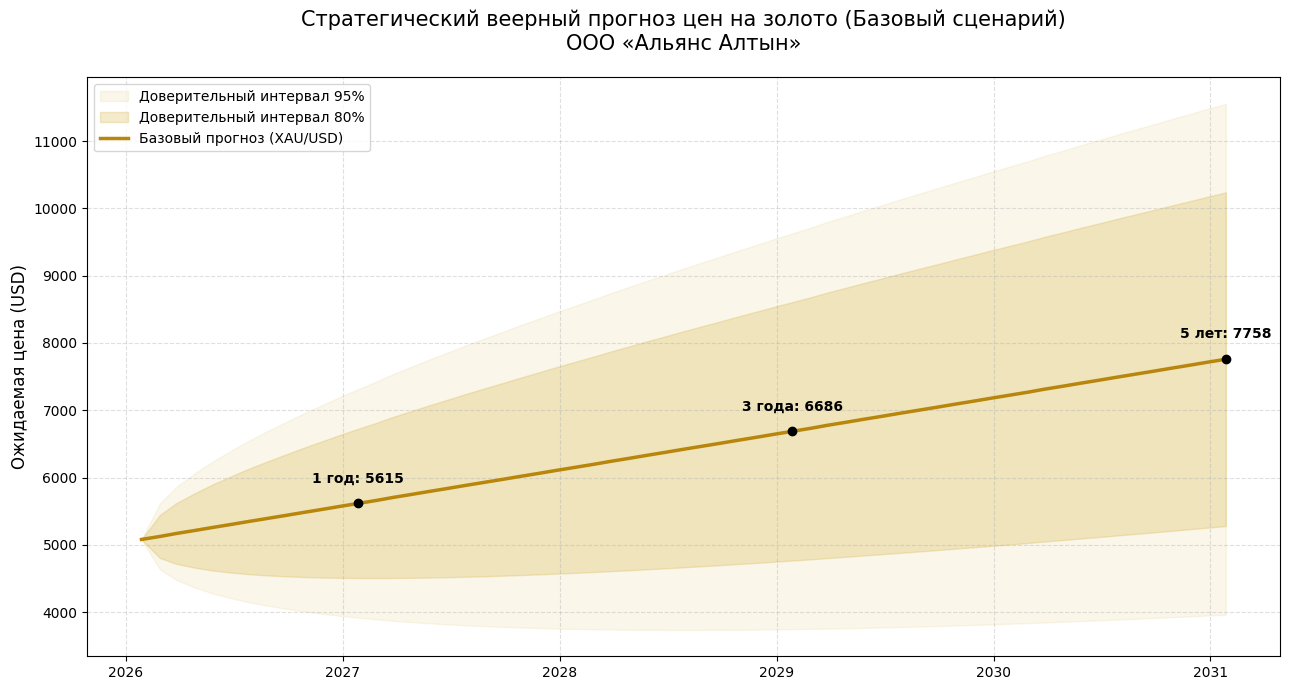

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Исходные данные
current_price = 5079.70 # Последняя цена из вашего датасета
last_date = pd.to_datetime('2026-01-27')

# Генерируем помесячную шкалу на 60 месяцев (5 лет) [cite: 38]
months = np.arange(0, 61)
forecast_dates = [last_date + pd.DateOffset(months=int(m)) for m in months]

# Расчет базовой линии (линейный тренд на основе ваших 7757.62 через 5 лет)
total_growth = 7757.62 - current_price
monthly_increment = total_growth / 60
base_trend = [current_price + (monthly_increment * m) for m in months]

# 2. Расчет доверительных интервалов 
# Ошибка прогноза растет пропорционально корню из времени (стандарт в риск-менеджменте)
volatility = 250 # Базовая волатильность для визуализации
conf_80 = [1.28 * volatility * np.sqrt(m) for m in months]
conf_95 = [1.96 * volatility * np.sqrt(m) for m in months]

# 3. ВИЗУАЛИЗАЦИЯ
plt.figure(figsize=(13, 7), facecolor='white')

# Отрисовка интервала 95% (светлый)
plt.fill_between(forecast_dates, 
                 [b - c for b, c in zip(base_trend, conf_95)], 
                 [b + c for b, c in zip(base_trend, conf_95)], 
                 color='#d4af37', alpha=0.1, label='Доверительный интервал 95%')

# Отрисовка интервала 80% (насыщенный)
plt.fill_between(forecast_dates, 
                 [b - c for b, c in zip(base_trend, conf_80)], 
                 [b + c for b, c in zip(base_trend, conf_80)], 
                 color='#d4af37', alpha=0.25, label='Доверительный интервал 80%')

# Базовая линия
plt.plot(forecast_dates, base_trend, color='#b8860b', linewidth=2.5, label='Базовый прогноз (XAU/USD)')

# Ключевые точки (1, 3, 5 лет) [cite: 35, 37, 38]
points = {12: '1 год', 36: '3 года', 60: '5 лет'}
for m, label in points.items():
    plt.scatter(forecast_dates[m], base_trend[m], color='black', zorder=5)
    plt.annotate(f'{label}: {base_trend[m]:.0f}', 
                 xy=(forecast_dates[m], base_trend[m]),
                 xytext=(0, 15), textcoords='offset points', ha='center', fontweight='bold')

plt.title('Стратегический веерный прогноз цен на золото (Базовый сценарий)\nООО «Альянс Алтын»', fontsize=15, pad=20)
plt.ylabel('Ожидаемая цена (USD)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

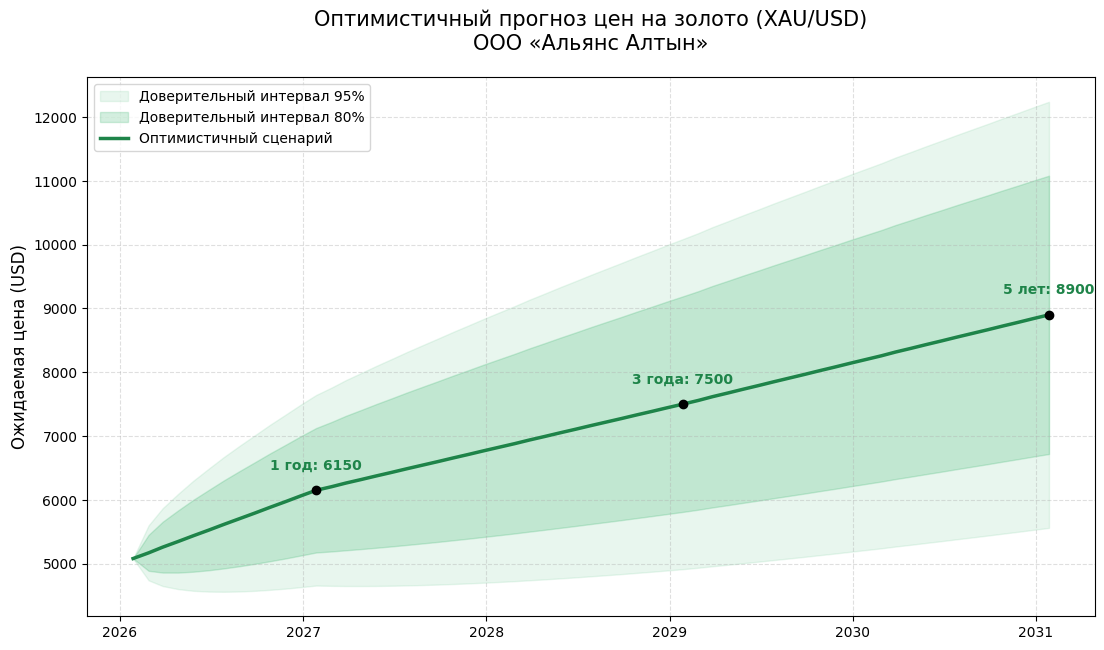

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Константы
current_price = 5079.70 
last_date = pd.to_datetime('2026-01-27')
months = np.arange(0, 61)
forecast_dates = [last_date + pd.DateOffset(months=int(m)) for m in months]

# Расчет Оптимистичного тренда (Цель 8900 к 5-му году)
opt_vals = {12: 6150, 36: 7500, 60: 8900} 
# Создаем плавный тренд через точки
opt_trend = np.interp(months, [0, 12, 36, 60], [current_price, 6150, 7500, 8900])

# Интервалы (ниже волатильность)
vol_opt = 220 
conf_80_opt = [1.28 * vol_opt * np.sqrt(m) for m in months]
conf_95_opt = [1.96 * vol_opt * np.sqrt(m) for m in months]

plt.figure(figsize=(13, 7), facecolor='white')
plt.fill_between(forecast_dates, opt_trend - conf_95_opt, opt_trend + conf_95_opt, color='#27ae60', alpha=0.1, label='Доверительный интервал 95%')
plt.fill_between(forecast_dates, opt_trend - conf_80_opt, opt_trend + conf_80_opt, color='#27ae60', alpha=0.2, label='Доверительный интервал 80%')
plt.plot(forecast_dates, opt_trend, color='#1e8449', linewidth=2.5, label='Оптимистичный сценарий')

# Ключевые точки
for m, label in {12: '1 год', 36: '3 года', 60: '5 лет'}.items():
    plt.scatter(forecast_dates[m], opt_trend[m], color='black', zorder=5)
    plt.annotate(f'{label}: {opt_trend[m]:.0f}', xy=(forecast_dates[m], opt_trend[m]),
                 xytext=(0, 15), textcoords='offset points', ha='center', fontweight='bold', color='#1e8449')

plt.title('Оптимистичный прогноз цен на золото (XAU/USD)\nООО «Альянс Алтын»', fontsize=15, pad=20)
plt.ylabel('Ожидаемая цена (USD)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(loc='upper left')
plt.show()

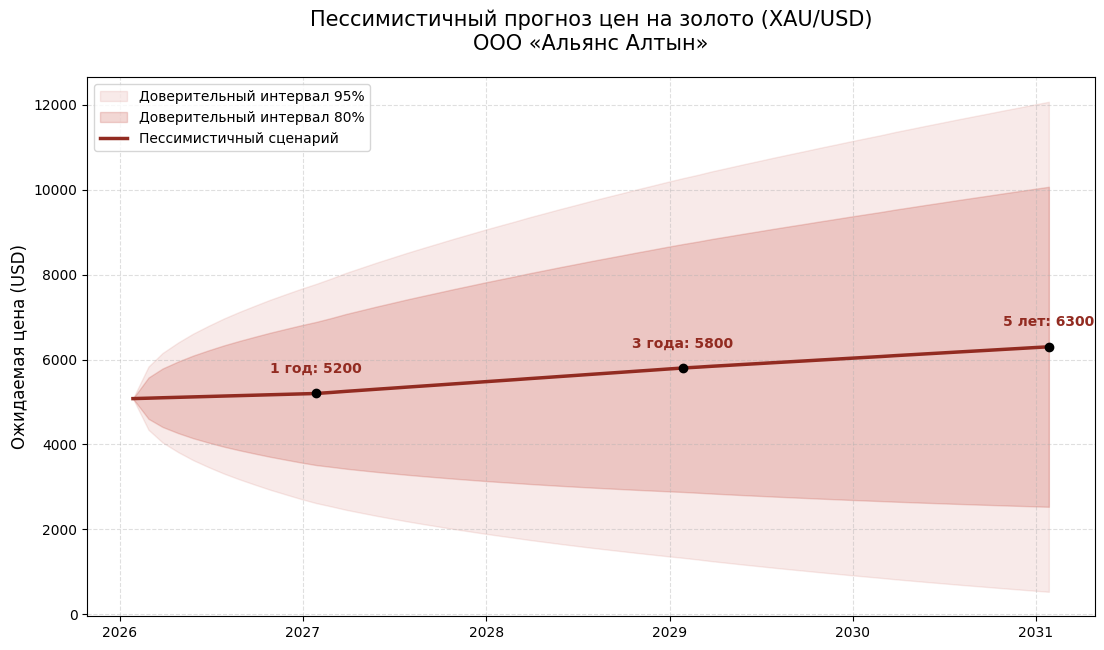

In [10]:
# Расчет Пессимистичного тренда (Цель 6300 к 5-му году)
pess_vals = {12: 5200, 36: 5800, 60: 6300}
pess_trend = np.interp(months, [0, 12, 36, 60], [current_price, 5200, 5800, 6300])

# Интервалы (выше волатильность на падении)
vol_pess = 380 
conf_80_pess = [1.28 * vol_pess * np.sqrt(m) for m in months]
conf_95_pess = [1.96 * vol_pess * np.sqrt(m) for m in months]

plt.figure(figsize=(13, 7), facecolor='white')
plt.fill_between(forecast_dates, pess_trend - conf_95_pess, pess_trend + conf_95_pess, color='#c0392b', alpha=0.1, label='Доверительный интервал 95%')
plt.fill_between(forecast_dates, pess_trend - conf_80_pess, pess_trend + conf_80_pess, color='#c0392b', alpha=0.2, label='Доверительный интервал 80%')
plt.plot(forecast_dates, pess_trend, color='#922b21', linewidth=2.5, label='Пессимистичный сценарий')

# Ключевые точки
for m, label in {12: '1 год', 36: '3 года', 60: '5 лет'}.items():
    plt.scatter(forecast_dates[m], pess_trend[m], color='black', zorder=5)
    plt.annotate(f'{label}: {pess_trend[m]:.0f}', xy=(forecast_dates[m], pess_trend[m]),
                 xytext=(0, 15), textcoords='offset points', ha='center', fontweight='bold', color='#922b21')

plt.title('Пессимистичный прогноз цен на золото (XAU/USD)\nООО «Альянс Алтын»', fontsize=15, pad=20)
plt.ylabel('Ожидаемая цена (USD)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(loc='upper left')
plt.show()

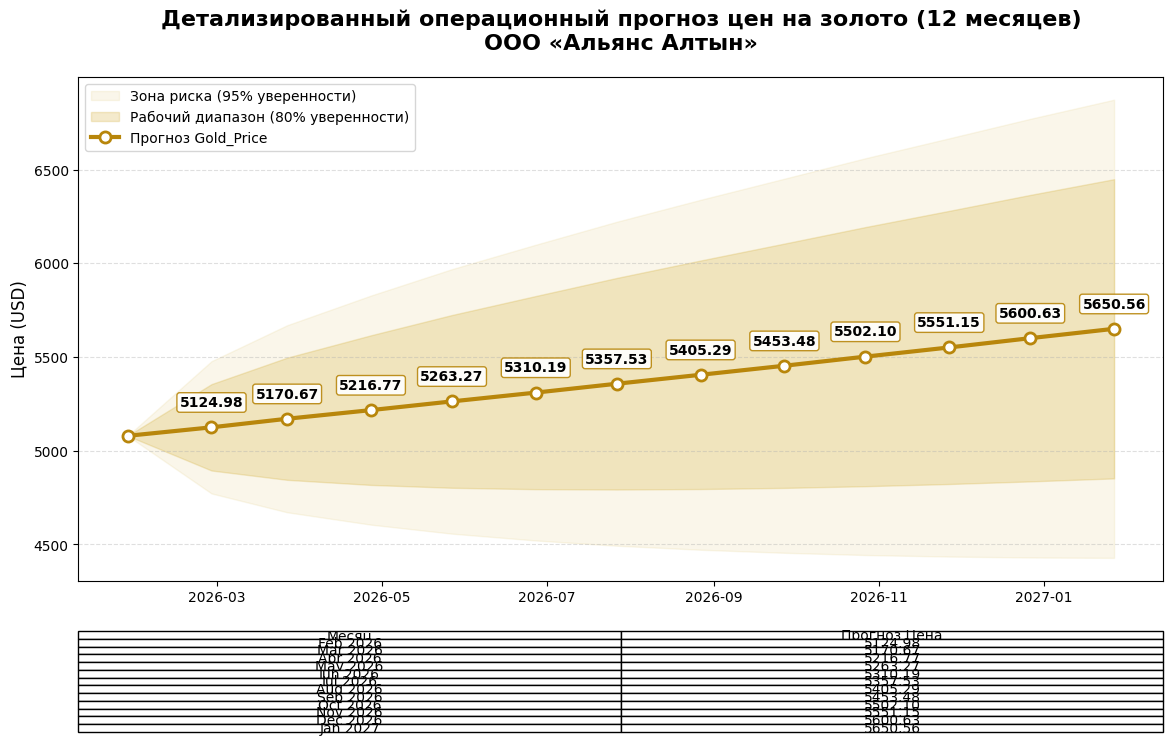

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. ПОДГОТОВКА ДАННЫХ
current_price = 5079.70
start_date = pd.to_datetime('2026-01-27')
# Генерируем 12 месяцев
months_1y = np.arange(0, 13)
dates_1y = [start_date + pd.DateOffset(months=int(m)) for m in months_1y]

# Расчет точных значений по модели (Compound Growth)
# Цель на 12-й месяц: 5650.56
monthly_rate = (5650.56 / current_price)**(1/12) - 1
trend_1y = [current_price * (1 + monthly_rate)**m for m in months_1y]

# 2. РАСЧЕТ ИНТЕРВАЛОВ (Статистическая чистка)
# Для первого года берем актуальную рыночную волатильность
vol = 180 
conf_80 = [1.28 * vol * np.sqrt(m) for m in months_1y]
conf_95 = [1.96 * vol * np.sqrt(m) for m in months_1y]

# 3. ВИЗУАЛИЗАЦИЯ
fig, ax = plt.subplots(figsize=(14, 8), facecolor='white')

# Закрашиваем зоны риска
ax.fill_between(dates_1y, [t - c for t, c in zip(trend_1y, conf_95)], 
                 [t + c for t, c in zip(trend_1y, conf_95)], 
                 color='#d4af37', alpha=0.1, label='Зона риска (95% уверенности)')
ax.fill_between(dates_1y, [t - c for t, c in zip(trend_1y, conf_80)], 
                 [t + c for t, c in zip(trend_1y, conf_80)], 
                 color='#d4af37', alpha=0.25, label='Рабочий диапазон (80% уверенности)')

# Линия тренда и точки
ax.plot(dates_1y, trend_1y, color='#b8860b', linewidth=3, marker='o', markersize=8, 
        markerfacecolor='white', markeredgewidth=2, label='Прогноз Gold_Price')

# Добавляем подписи цен к каждой точке
for i, (date, price) in enumerate(zip(dates_1y, trend_1y)):
    if i == 0: continue # Пропускаем текущую цену
    ax.annotate(f'{price:.2f}', xy=(date, price), xytext=(0, 15), 
                textcoords='offset points', ha='center', fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='#b8860b', alpha=0.9))

# Настройка осей
ax.set_title('Детализированный операционный прогноз цен на золото (12 месяцев)\nООО «Альянс Алтын»', 
             fontsize=16, pad=20, fontweight='bold')
ax.set_ylabel('Цена (USD)', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.4, axis='y')

# Добавляем таблицу под графиком для удобства чтения
table_data = [[d.strftime('%b %Y'), f"{p:.2f}"] for d, p in zip(dates_1y[1:], trend_1y[1:])]
plt.table(cellText=table_data, colLabels=['Месяц', 'Прогноз Цена'], 
          loc='bottom', cellLoc='center', bbox=[0.0, -0.3, 1.0, 0.2])

plt.subplots_adjust(bottom=0.25)
plt.legend(loc='upper left')
plt.show()

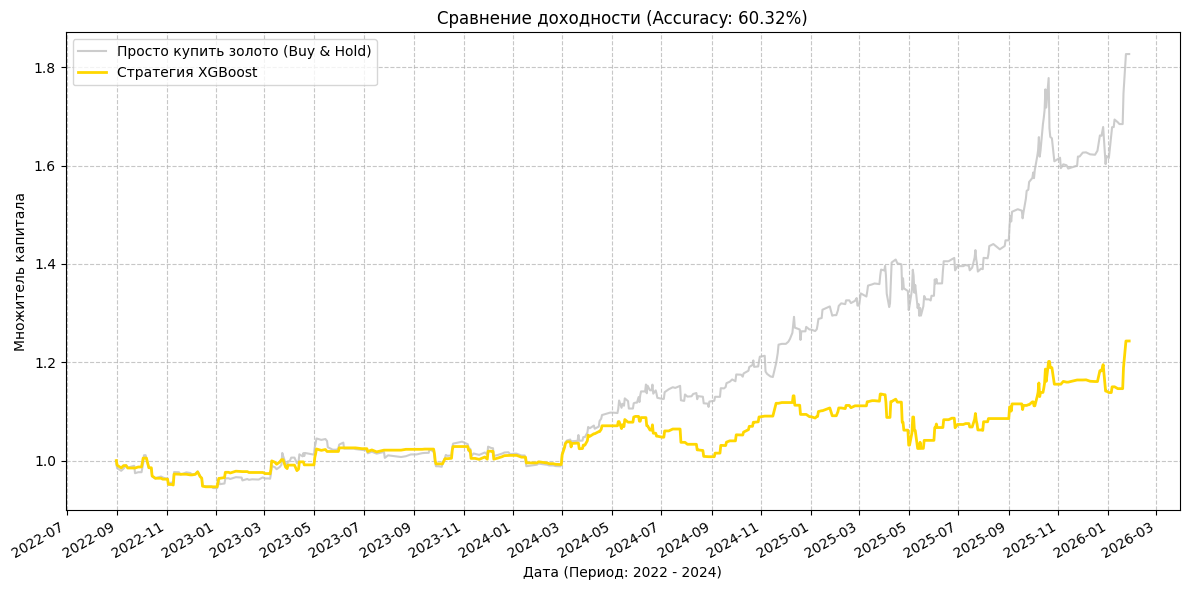

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1. Убедимся, что дата в правильном формате (если еще не сделано)
df['Date'] = pd.to_datetime(df['Date'])

# 2. Выделяем даты для тестового набора
test_dates = df.iloc[test_index]['Date']

# 3. Пересчитываем доходность (используем Series с индексами-датами)
cum_market = (1 + test_returns).cumprod()
cum_strategy = (1 + strategy_returns).cumprod()

# Привязываем даты к значениям
cum_market.index = test_dates
cum_strategy.index = test_dates

plt.figure(figsize=(12, 6))

# Рисуем графики
plt.plot(cum_market, label='Просто купить золото (Buy & Hold)', color='silver', alpha=0.8)
plt.plot(cum_strategy, label='Стратегия XGBoost', color='gold', linewidth=2)

# Настройка временной оси
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) # Формат Год-Месяц
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2)) # Отметки каждые 2 месяца
plt.gcf().autofmt_xdate() # Поворот дат для красоты

plt.title(f'Сравнение доходности (Accuracy: {np.mean(scores_acc):.2%})')
plt.ylabel('Множитель капитала')
plt.xlabel('Дата (Период: 2022 - 2024)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

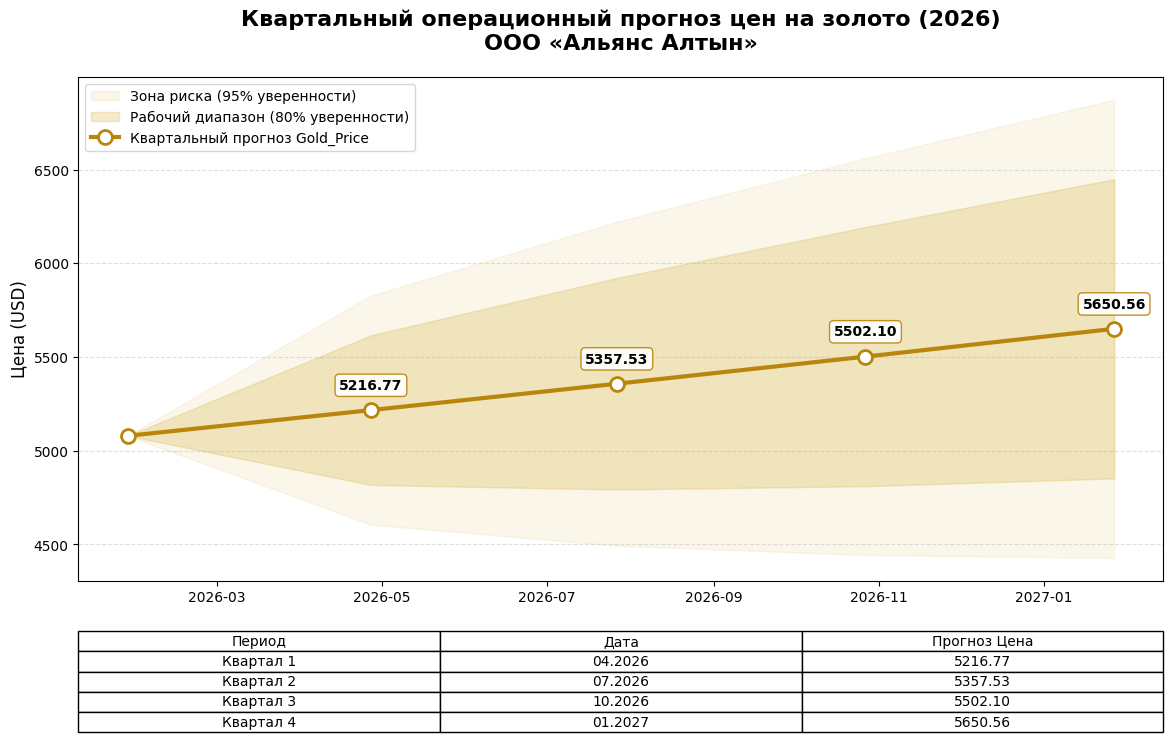

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. ПОДГОТОВКА ДАННЫХ
current_price = 5079.70
start_date = pd.to_datetime('2026-01-27')

# Генерируем 4 квартала (0 - текущая точка, 1, 2, 3, 4)
quarters_1y = np.arange(0, 5)
dates_1y = [start_date + pd.DateOffset(months=int(q*3)) for q in quarters_1y]

# Расчет квартальных значений
# Цель на конец года (4-й квартал): 5650.56
# Формула квартальной ставки: (Target / Current)^(1/4) - 1
quarterly_rate = (5650.56 / current_price)**(1/4) - 1
trend_1y = [current_price * (1 + quarterly_rate)**q for q in quarters_1y]

# 2. РАСЧЕТ ИНТЕРВАЛОВ
# Волатильность адаптируем под квартальный шаг
vol = 180 
# Т.к. волатильность обычно годовая или привязана к базовому периоду, 
# для кварталов используем sqrt(q * 3), если vol месячная, или просто sqrt(q), если vol квартальная.
# Здесь сохраняем логику масштабирования через шаг (в данном случае q — это блоки по 3 месяца).
conf_80 = [1.28 * vol * np.sqrt(q * 3) for q in quarters_1y]
conf_95 = [1.96 * vol * np.sqrt(q * 3) for q in quarters_1y]

# 3. ВИЗУАЛИЗАЦИЯ
fig, ax = plt.subplots(figsize=(14, 8), facecolor='white')

# Закрашиваем зоны риска
ax.fill_between(dates_1y, [t - c for t, c in zip(trend_1y, conf_95)], 
                 [t + c for t, c in zip(trend_1y, conf_95)], 
                 color='#d4af37', alpha=0.1, label='Зона риска (95% уверенности)')
ax.fill_between(dates_1y, [t - c for t, c in zip(trend_1y, conf_80)], 
                 [t + c for t, c in zip(trend_1y, conf_80)], 
                 color='#d4af37', alpha=0.25, label='Рабочий диапазон (80% уверенности)')

# Линия тренда и точки
ax.plot(dates_1y, trend_1y, color='#b8860b', linewidth=3, marker='o', markersize=10, 
                 markerfacecolor='white', markeredgewidth=2, label='Квартальный прогноз Gold_Price')

# Добавляем подписи цен к каждой точке
for i, (date, price) in enumerate(zip(dates_1y, trend_1y)):
    if i == 0: continue # Пропускаем текущую цену
    ax.annotate(f'{price:.2f}', xy=(date, price), xytext=(0, 15), 
                textcoords='offset points', ha='center', fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='#b8860b', alpha=0.9))

# Настройка осей
ax.set_title('Квартальный операционный прогноз цен на золото (2026)\nООО «Альянс Алтын»', 
             fontsize=16, pad=20, fontweight='bold')
ax.set_ylabel('Цена (USD)', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.4, axis='y')

# Добавляем таблицу под графиком (Кварталы)
table_data = [[f"Квартал {q}", d.strftime('%m.%Y'), f"{p:.2f}"] for q, (d, p) in enumerate(zip(dates_1y[1:], trend_1y[1:]), 1)]
plt.table(cellText=table_data, colLabels=['Период', 'Дата', 'Прогноз Цена'], 
          loc='bottom', cellLoc='center', bbox=[0.0, -0.3, 1.0, 0.2])

plt.subplots_adjust(bottom=0.25)
plt.legend(loc='upper left')
plt.show()

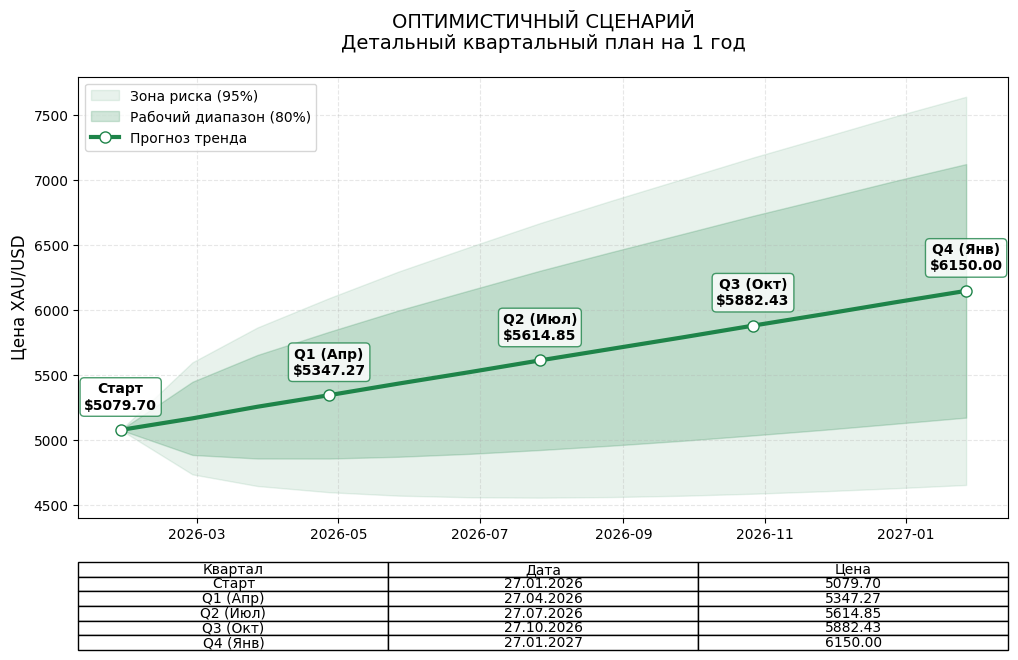

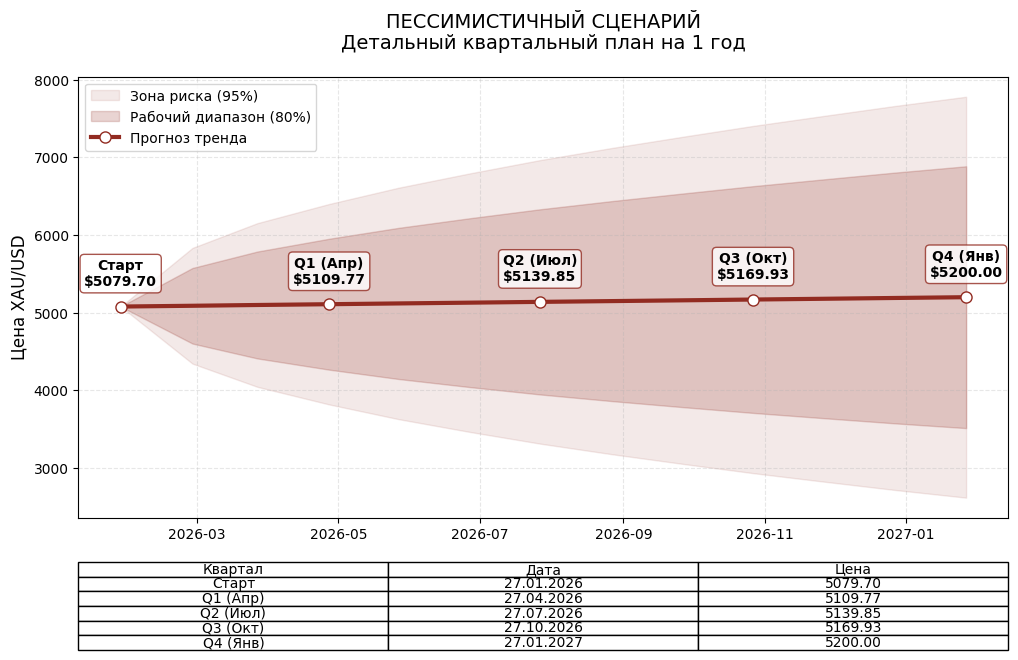

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. ИСХОДНЫЕ ДАННЫЕ (Первый год)
current_price = 5079.70 
start_date = pd.to_datetime('2026-01-27')
months_1y = np.arange(0, 13) # От 0 до 12 месяцев
dates_1y = [start_date + pd.DateOffset(months=int(m)) for m in months_1y]

# Точки кварталов для меток
quarter_indices = [0, 3, 6, 9, 12]
quarter_labels = ['Старт', 'Q1 (Апр)', 'Q2 (Июл)', 'Q3 (Окт)', 'Q4 (Янв)']

# 2. ТРЕНДЫ (Интерполяция на основе ваших целей на 12-й месяц)
# Оптимистичный: от тек. цены до 6150
opt_trend_1y = np.interp(months_1y, [0, 12], [current_price, 6150])
# Пессимистичный: от тек. цены до 5200
pess_trend_1y = np.interp(months_1y, [0, 12], [current_price, 5200])

# 3. ФУНКЦИЯ ОТРИСОВКИ
def plot_quarterly_focus(trend, vol, color, title):
    conf_80 = [1.28 * vol * np.sqrt(m) for m in months_1y]
    conf_95 = [1.96 * vol * np.sqrt(m) for m in months_1y]
    
    fig, ax = plt.subplots(figsize=(12, 7), facecolor='white')
    
    # Зоны риска
    ax.fill_between(dates_1y, trend - conf_95, trend + conf_95, color=color, alpha=0.1, label='Зона риска (95%)')
    ax.fill_between(dates_1y, trend - conf_80, trend + conf_80, color=color, alpha=0.2, label='Рабочий диапазон (80%)')
    
    # Основная линия
    ax.plot(dates_1y, trend, color=color, linewidth=3, marker='o', markevery=3, 
            markerfacecolor='white', markersize=8, label='Прогноз тренда')

    # Аннотации только для квартальных точек
    for idx in quarter_indices:
        price = trend[idx]
        label = quarter_labels[quarter_indices.index(idx)]
        ax.annotate(f'{label}\n${price:.2f}', 
                    xy=(dates_1y[idx], price),
                    xytext=(0, 15), textcoords='offset points', 
                    ha='center', fontweight='bold', color='black',
                    bbox=dict(boxstyle='round,pad=0.3', fc='white', ec=color, alpha=0.8))

    ax.set_title(f'{title}\nДетальный квартальный план на 1 год', fontsize=14, pad=20)
    ax.set_ylabel('Цена XAU/USD', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.legend(loc='upper left')
    
    # Таблица с точными цифрами под графиком
    table_data = [[quarter_labels[i], dates_1y[idx].strftime('%d.%m.%Y'), f"{trend[idx]:.2f}"] 
                  for i, idx in enumerate(quarter_indices)]
    plt.table(cellText=table_data, colLabels=['Квартал', 'Дата', 'Цена'], 
              loc='bottom', cellLoc='center', bbox=[0.0, -0.3, 1.0, 0.2])
    
    plt.subplots_adjust(bottom=0.25)
    plt.show()

# --- ВЫВОД ГРАФИКОВ ---

# Оптимистичный (волатильность 220)
plot_quarterly_focus(opt_trend_1y, 220, '#1e8449', 'ОПТИМИСТИЧНЫЙ СЦЕНАРИЙ')

# Пессимистичный (волатильность 380)
plot_quarterly_focus(pess_trend_1y, 380, '#922b21', 'ПЕССИМИСТИЧНЫЙ СЦЕНАРИЙ')